In [1]:
# imports
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt


/cluster/courses/deep_learning/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [23]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
model.cuda()

Weights already downloaded
Load_state output <All keys matched successfully>


BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=10, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
  )
  (layernorms): ModuleList(
    (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

In [27]:
x = torch.randn(1, 3, 64, 64)
x = x.flatten()
x.shape

torch.Size([12288])

In [ ]:
# calculate mean for the train set

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [ ]:

num_class = 10
cmeans = [[] for i in range(num_class)]

for x,y in loader:
    for c in range(num_class):
        cmeans[c].append(x[y==c])


In [ ]:
clist = [torch.cat(cmeans[i]).mean(dim=0) for i in range(num_class)]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(clist[9].numpy().transpose(1,2,0))

In [4]:
x_c = nn.parameter.Parameter(torch.randn(3,64,64))

In [5]:
model.parameters()

<generator object Module.parameters at 0x153b9a7c7df0>

In [35]:
len(cifar10_dataset.targets)

50000

Files already downloaded and verified


In [6]:
class ClassMaxim(nn.Module):
    def __init__(self,num_class, centers=None):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(num_class, 3, 64, 64)) # [nn.parameter.Parameter(torch.randn(3,64,64)) for i in range(num_class)]
        if centers!=None:
            self.x_c = nn.parameter.Parameter(centers.clone())    
        self.clone = self.x_c.clone()

In [ ]:
cclist = [c.unsqueeze(0) for c in clist]

In [ ]:
# cat centers
centers = torch.cat(cclist)
centers.shape

In [7]:
# create the model
clsmax = ClassMaxim(num_class=10, centers=centers)

In [8]:
clsmax.clone==clsmax.x_c

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [9]:
clsmax

ClassMaxim()

In [10]:
for param in clsmax.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([10, 3, 64, 64])


In [11]:
clsmax.x_c[0].shape

torch.Size([3, 64, 64])

In [12]:
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

In [16]:
list(clsmax.parameters())

[Parameter containing:
 tensor([[[[-0.0700, -0.4102,  0.9066,  ..., -0.8297, -0.3176, -0.8001],
           [ 0.6847,  0.0125,  0.2039,  ..., -0.9233,  0.4282,  1.3928],
           [-0.3251,  0.1787, -2.1882,  ...,  1.3725, -0.2974, -0.0932],
           ...,
           [-0.7541, -0.3764, -0.7750,  ...,  1.0119, -0.9026,  0.2912],
           [ 0.0060,  0.4458,  0.4444,  ...,  1.6949,  0.5759,  1.3701],
           [ 0.7710,  0.1809,  1.5173,  ..., -0.1812, -1.2684,  1.1784]],
 
          [[ 2.6158,  1.8353, -0.3529,  ...,  0.1768, -0.4770, -0.3010],
           [ 1.4980, -0.3951, -0.3576,  ..., -0.7530, -1.6313, -0.4262],
           [ 0.9705,  1.9270,  0.8925,  ...,  0.7532, -0.0478, -1.2610],
           ...,
           [-0.0871, -1.5265, -1.2937,  ...,  0.1263,  1.4263, -0.4566],
           [-1.0477, -1.8143,  1.1187,  ...,  0.0770,  0.3628,  0.3496],
           [ 1.0621,  1.8634,  0.7282,  ..., -0.7144, -1.2664,  1.7793]],
 
          [[ 0.4485, -0.5502,  0.6837,  ...,  0.4865,  1.0472, 

In [17]:
from utils.parsers import get_training_parser

parser = get_training_parser()
args = parser.parse_args(args=[])

In [18]:
epoch = 100
num_class=10

loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)
opt = get_optimizer(args.optimizer)(clsmax.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = get_scheduler(opt, args.scheduler, **args.__dict__)

In [19]:
torch.randn(3,64,64).shape

torch.Size([3, 64, 64])

In [20]:
args.epochs

500

In [178]:
import time

In [179]:
start = time.time()
model.eval() # fixed model

# total_acc, total_top5 = AverageMeter(), AverageMeter()
total_loss = AverageMeter()

for step in range(5000):
    for c in range(10):
        xx = clsmax.x_c[c].flatten().cuda()
        preds = model(xx)
        targs = torch.tensor(c).cuda()


        (-preds[c]).backward()
        # loss = loss_fn(preds, targs)
        
        # loss = loss / args.accum_steps
        # loss.backward()

        print(preds[c])
        
        opt.step()
        opt.zero_grad()
    
        total_loss.update(loss.item() * args.accum_steps, 1)

end = time.time()

scheduler.step()

tensor(45.3484, device='cuda:0', grad_fn=<DivBackward0>)
tensor(45.2723, device='cuda:0', grad_fn=<DivBackward0>)
tensor(45.1960, device='cuda:0', grad_fn=<DivBackward0>)
tensor(45.1195, device='cuda:0', grad_fn=<DivBackward0>)
tensor(45.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.9659, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.8887, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.8114, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.7339, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.6562, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.5782, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.5001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.4218, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.3433, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.2646, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.1857, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.1066, device='cuda:0', grad_fn=<DivBackward0>)
tensor(44.0274, device='cuda:0'

In [180]:
xx.flatten().shape

torch.Size([12288])

In [181]:
clsmax.x_c[c]

tensor([[[-1.3053,  0.5204,  1.3291,  ...,  0.5805,  0.4357,  0.1413],
         [-0.7746,  0.6462, -0.0318,  ..., -1.0754,  0.8482, -0.3621],
         [ 0.6840,  0.9308, -1.9731,  ..., -0.3493, -1.1268,  0.1389],
         ...,
         [ 0.4721, -1.2380, -1.2970,  ...,  1.8707,  0.2300,  1.0953],
         [ 0.5778, -0.2373,  0.3883,  ...,  0.2198, -1.1090,  0.8280],
         [ 0.4887,  0.6507, -1.6122,  ..., -0.6338,  0.8978,  0.0531]],

        [[ 0.9698,  2.1513,  0.5861,  ...,  0.3595,  0.7472,  0.6398],
         [ 0.6077, -0.3846,  0.8063,  ..., -0.1440,  0.2196, -0.4931],
         [ 1.5507, -0.4357,  0.3504,  ...,  0.6970, -1.3489, -0.5419],
         ...,
         [-0.6151,  0.7003, -0.5208,  ..., -1.4758,  0.2957,  1.0528],
         [ 0.2661,  0.2559, -0.3410,  ..., -0.8493, -0.5455,  0.8498],
         [-0.0494, -0.5812, -0.2251,  ...,  0.3643, -0.8580, -0.9166]],

        [[-0.3975,  1.1459,  1.7081,  ..., -0.4252,  0.0782, -1.5503],
         [ 0.1589,  0.4985, -2.1946,  ...,  1

In [182]:
loss

tensor(1.1814, device='cuda:0', grad_fn=<DivBackward0>)

In [183]:
import matplotlib.pyplot as plt

In [184]:
clsmax.x_c[c].shape

torch.Size([3, 64, 64])

In [ ]:
torch.norm(clsmax.x_c[0])

0

In [ ]:
torch.norm(centers[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


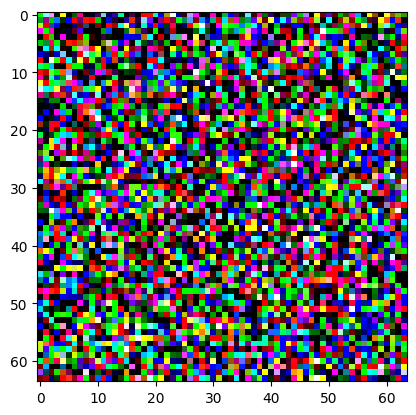

In [186]:
plt.imshow(clsmax.x_c[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


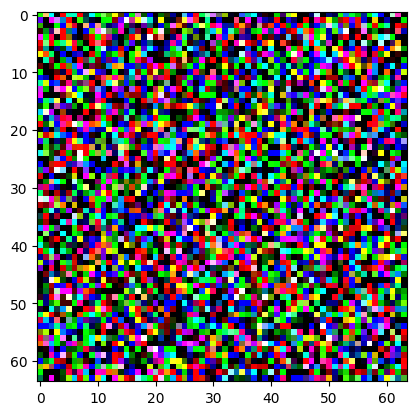

In [166]:
plt.imshow(clsmax.clone[0].detach().numpy().transpose(1,2,0))

In [187]:
clsmax.clone[0]==clsmax.x_c[0]

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [